In [8]:
import pandas as pd
def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# Ejercicio


En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Uno de los mayores problemas en el internet de hoy en día es la presencia de actitudes negativas hacia algunos colectivos en relación a su etnia, género, religión o ideología política. En este ejercicio trabajaremos con un conjunto de datos reales, etiquetados manualmente, procedentes de la plataforma [Kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data). Originalmente, a cada documento del dataset se le asignó una de las siguientes categorías:
- *religion*
- *age*
- *ethnicity*
- *gender*
- *other_cyberbullying*
- *not_cyberbullying*


El objetivo inicial del dataset era su uso para entrenar un modelo capaz de detectar el tipo de contenido de odio presente en internet según el colectivo al que se atacaba. En este caso, para simplificar el ejercicio, se ha generado una función `load_prepare_data()` que cambia las categorías del dataset obteníendose al final 2 categorías con valor 1 o 0, indicando si el tweet tiene contenido de odio

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. Será necesario incorporar características adicionales como el sentimiento o características léxicas.

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


**Nota 1**: El ejercicio propuesto es similar a los ejercicios de clasificación visto en clase, por lo que es importante que documentéis y expliquéis adecuadamente (con vuestras palabras) los procesos llevados a cabo en el ejercicio. No hacerlo puede llegar a penalizar hasta 1 punto en la calificación final.

**Nota 2**: Cualquier cálculo adicional a los vistos en clase (visualizaciones, nuevas características añadidas al modelo...) será valorado positivamente en la calificación.

## 0. Imports


In [9]:
import pandas as pd

In [10]:
!pip install contractions

import nltk
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
import contractions
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [11]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
# Path de datos alternativos en caso de que el anterior no funcione (al estar alojado en github puede haber limitaciones
# en la descarga.
# path_data = "https://zenodo.org/records/10938455/files/cyberbullying_tweets.csv?download=1"
dataset = load_prepare_data(path_data)

In [12]:
dataset.head(4)

,tweet_text,cyberbullying
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0


## 2. Análisis exploratorio

En este apartado realizaré el debido análisis explotario de los datos que nos han dado antes de realizar su preprocesado y la normalización. Nos dara un resumen claro de como se comportan nuestros datos y ayudar a interpretarlos.

* **Número de documentos y columnas: ***

Mostraré cuantos documentos tenemos en el dataset y la cantidad de columnas, que con el .head() previo vimos que eran dos columnas.

In [13]:
print("Tenemos un conjunto de {} documentos".format(len(dataset)))
print("El dataset tiene {} columnas".format(dataset.shape[1]))

Tenemos un conjunto de 47692 documentos
El dataset tiene 2 columnas


* **Número de documentos duplicados:**

Comprobar si existen duplicados y eliminar las filas que poseen algún valor vacío (NA) y eliminar también dichos duplicados.

In [14]:
print("Existen {} documentos duplicados".format(np.sum(dataset.duplicated(subset=["tweet_text"]))))

Existen 1675 documentos duplicados


Ahora voy a proceder a eliminar esos duplicados.

In [15]:
dataset = dataset.drop_duplicates(subset=["tweet_text"], keep= 'first')
print("Después de quitar duplicados tengo un conjunto de {} documentos".format(dataset.shape[0]))

Después de quitar duplicados tengo un conjunto de 46017 documentos


Compruebo que no hayan Nulls en ambas columnas de nuestro dataset.

In [16]:
print("Hay {} valores vacíos en los tweet_text y {} valores vacíos en las etiquetas cyberbullying en los datos".format(np.sum(dataset.isnull())[0],
                                                                                                        np.sum(dataset.isnull())[1]))

Hay 0 valores vacíos en los tweet_text y 0 valores vacíos en las etiquetas cyberbullying en los datos


* **Número de documentos por cada clase:**

Aquí contaremos el número de elementos que posee cada clase de nuestra columna categoríca cyberbullying donde solo hay dos valores posibles con valor 1 o 0, indicando si el tweet tiene contenido de odio.

In [17]:
print(dataset["cyberbullying"].value_counts())

cyberbullying
1    38080
0     7937
Name: count, dtype: int64


In [18]:
# Número de elementos de cada clase:
dataset.groupby(['cyberbullying']).count()

,tweet_text
cyberbullying,
0,7937
1,38080


Vamos a dibujar un histograma con las clases para practicar la visualización y comunicación de resultados.

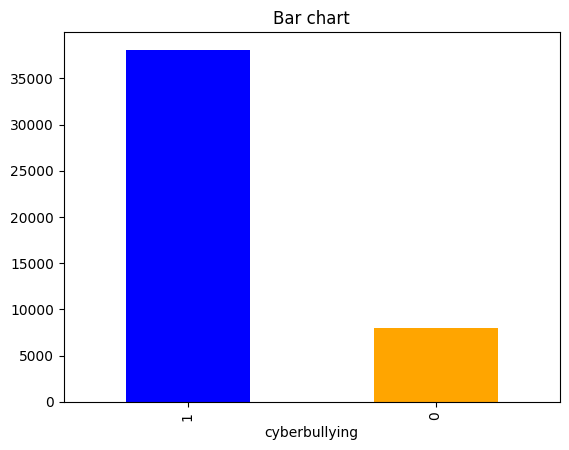

In [19]:
ax, fig = plt.subplots()
etiquetas = dataset.cyberbullying.value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

Podemos observar que esta bastante desbalanceado las categorías de nuestra variable cyberbullying. Mostrando una diferente muy amplía de 30142 entre ambas categorias 0 y 1. Podemos optar para realizar una gestión de balanceo con un oversampling con la técnica avanzada de SMOTE para no perder información.

* **Distribución de la longitud de los tweet en caracteres:**

Ahora quiero realizar un cálculo de la longitud de los caracteres de cada uno de los textos de los documentos y realizar un histograma para poder visualizar si hay outliers y anomalias en el dataset.

In [20]:
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))

<Figure size 1400x1200 with 0 Axes>

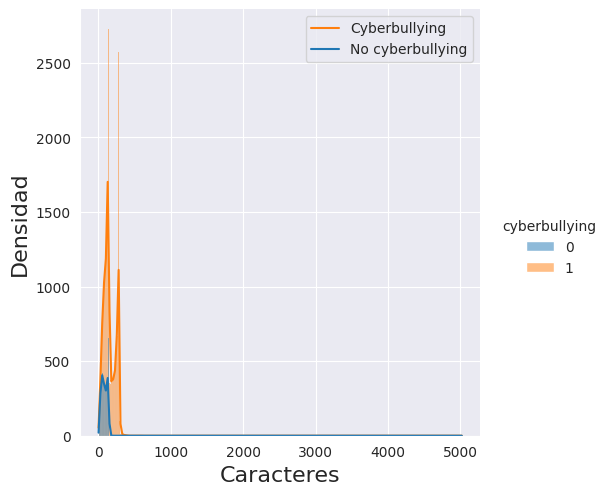

In [21]:
fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")

sns.displot(data=dataset, x="char_len", hue="cyberbullying", kde=True, legend=True)
plt.legend(["Cyberbullying", "No cyberbullying"])

plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

plt.show()

No lo visualizo muy bien asi, voy a intentar crear un gráfico limitando el eje X a 300.

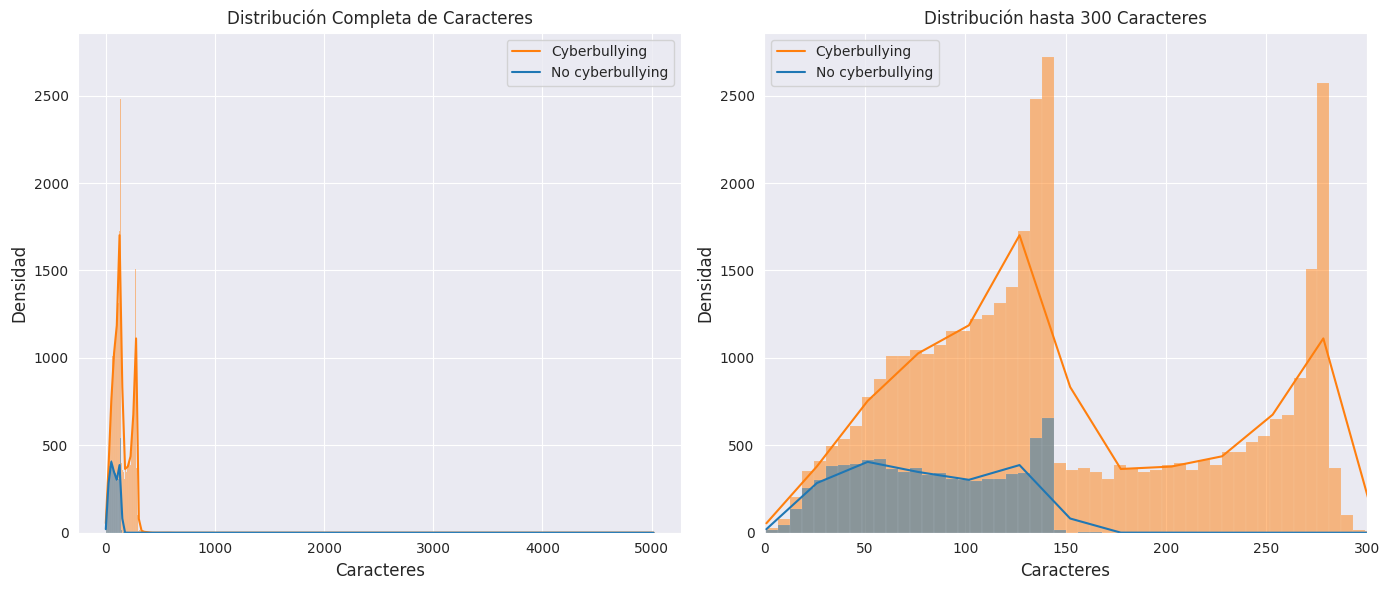

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Una fila, dos columnas
sns.set_style("darkgrid")

# Primer gráfico: Distribución completa
sns.histplot(data=dataset, x="char_len", hue="cyberbullying", kde=True, ax=axes[0], legend=True)
axes[0].set_title('Distribución Completa de Caracteres')
axes[0].set_xlabel('Caracteres', fontsize=12)
axes[0].set_ylabel('Densidad', fontsize=12)
axes[0].legend(["Cyberbullying", "No cyberbullying"])

# Segundo gráfico: Limitado a 300 caracteres
sns.histplot(data=dataset, x="char_len", hue="cyberbullying", kde=True, ax=axes[1], legend=True)
axes[1].set_title('Distribución hasta 300 Caracteres')
axes[1].set_xlabel('Caracteres', fontsize=12)
axes[1].set_ylabel('Densidad', fontsize=12)
axes[1].set_xlim([0, 300])
axes[1].legend(["Cyberbullying", "No cyberbullying"])

plt.tight_layout()
plt.show()

Con esta visualización podemos ver que no hay tweets de más de 150 caracteres con dicha presencia de cyberbullying por lo que nos han sido presentadas dos opciones:

"1. Entrenar el modelo con todos los datos y utilizar una característica adicional como la longitud de caracteres del texto para controlar este efecto (es la más recomendable para no perder información).
2. Limitarte a utilizar los datos de tweets que tienen hasta 150 caracteres. Si optas por esta opción deberías generar un test data que tenga datos por encima de los 150 caracteres."

In [23]:
dataset.head(1)

,tweet_text,cyberbullying,char_len
0,"In other words #katandandre, your food was cra...",0,61


Con la creación previa de "char_len", podemos ver la longitud de cada tweet.

Después de esto, he decidido irme por la opción 1, incluyendo esa nueva característica que ya cree previamente llamada "char_len", llevando la longitud del texto.

Utilizando esta opción de usar todos los datos, me permite mantener la mayor cantidad de datos posible para no perder información, lo cual es importante para el entrenamiento de cualquier modelo de machine learning y me ayuda a explorar si la longitud del tweet podria ser en si misma un predictor de la ausencia de cyberbullying, lo cual podria ser una caracteristica interesante y útil.

* **Análisis de contenido de los tweets:**

Utilizare para obtener esta visualización word cloud, donde representa visualmente los términos más frecuentes de un conjunto de textos, pero dando más fuerza a los que tengan más frecuencia.

In [24]:
from wordcloud import WordCloud

Para generar dichos gráficos necesito una variable que sea del tipo string que contenga todos los textos con los que queremos llevar a cabo la visualización. Obteniendo separadamente los tweets asociados a la categoría 0 y 1.

In [25]:
txt_cat0 = ",".join(dataset[dataset.cyberbullying==0].tweet_text.to_list())
txt_cat1 = ",".join(dataset[dataset.cyberbullying==1].tweet_text.to_list())

Necesito ahora crear un objeto WordCloud con la configuración que me permita obtener las visualizaciones.

In [26]:
from nltk.corpus import stopwords
en_stopwords = stopwords.words("english") # 'english'

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0,
                      contour_color='steelblue', stopwords=en_stopwords,
                      normalize_plurals = True, collocations=False)

Ya generado el objeto, puedo usarlo para llevar a cabo la generación visual.

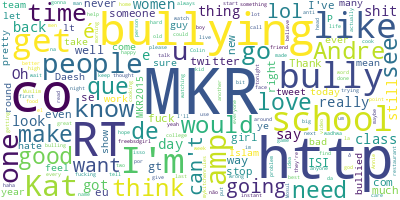

In [27]:
wordcloud.generate(txt_cat0)
wordcloud.to_image()

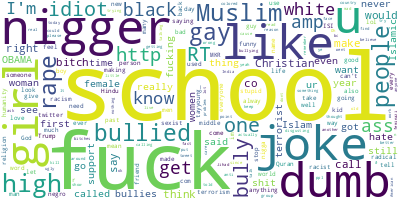

In [28]:
wordcloud.generate(txt_cat1)
wordcloud.to_image()

Después de visualizar detenidamente dichos resultados, veo y puedo observar que:

* En el wordcloud de la categoría 0, se observa que hay una alta presencia de URLs (https y co).
* En el wordcloud de la categoría 1, se observa que hay una menor presencia de URLs (https y co).

En general, se observan similitudes en los términos más presentes en ambas categorías como (bully, bullied, people, school, one, like.)

Este tipo de visualización nos permite obtener ideas para modelar el problema posteriormente.

## 3. Preprocesado y Normalización

A continuación, comenzamos con la parte del preprocesado, normalización y transformación.

**Normalización**

Para normalizar nuestros datos, vamos a realizar ciertas funciones que nos permitan realizar lo siguiente:

*   Eliminar espacios extra entre términos.
*   Transformar a minúsculas.
*   Reemplazar contracciones del inglés.
*   Normalizar URLs, menciones de twitter y números por tokens comunes.
*   Lematizar tokens, eliminar stopwords y eliminar sígnos de puntuación.

Dicho procedimiento lo realizaré combinando librerías como Spacy.

Como **1º paso**, voy a eliminar espacios extras del texto y transformar todos los caracteres a minúsculas

In [29]:
# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# To lower
def texto_to_lower(text):
  return text.lower()

In [30]:
# Espacios y minuscula
dataset["normalized"] = dataset["tweet_text"].progress_apply(lambda x: eliminar_espacios(x))
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: texto_to_lower(x))

  0%|          | 0/46017 [00:00<?, ?it/s]

  0%|          | 0/46017 [00:00<?, ?it/s]

In [31]:
dataset.head()

,tweet_text,cyberbullying,char_len,normalized
0,"In other words #katandandre, your food was cra...",0,61,"in other words #katandandre, your food was cra..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,why is #aussietv so white? #mkr #theblock #ima...
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,@xochitlsuckkks a classy whore? or more red ve...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103,"@jason_gio meh. :p thanks for the heads up, bu..."
4,@RudhoeEnglish This is an ISIS account pretend...,0,103,@rudhoeenglish this is an isis account pretend...


Ahora, voy a normalizar las contracciones y slang existentes en inglés

In [32]:
def replace_contraction(text):
    return contractions.fix(text, slang=True)

In [33]:
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: replace_contraction(x))

  0%|          | 0/46017 [00:00<?, ?it/s]

Después normalizamos URLs (tokens que comienzan por https), menciones de twitter (tokens que comienzan por @) y números. Optando por tokenizar el documento, y en función de las características del token sustituiremos el token o lo dejaremos igual.

In [34]:
from nltk.tokenize import TweetTokenizer, word_tokenize

In [35]:
tweet_tokenizer = TweetTokenizer()

In [36]:
# Paso la función que me ayudará a tokenizar

def normalizar_tokens(documento):
    # Dividir el documento en palabras
    palabras =  tweet_tokenizer.tokenize(documento) # tokenize(documento)

    # Reemplazar URLs, menciones de Twitter y números por los tokens correspondientes
    for i in range(len(palabras)):
        if palabras[i].startswith("http://") or palabras[i].startswith("https://") or palabras[i].startswith("www."):
            palabras[i] = "URL"
        elif palabras[i].startswith("@"): #startswith "@"
            palabras[i] = "MENTION"
        elif palabras[i].isdigit(): # .isdigit()
            palabras[i] = "NUM"

    # Unir las palabras de nuevo en un documento modificado
    documento_modificado = ' '.join(palabras)

    return documento_modificado

In [37]:
dataset["normalized"] = dataset["normalized"].progress_apply(lambda x: normalizar_tokens(x))

  0%|          | 0/46017 [00:00<?, ?it/s]

In [38]:
dataset.head()

,tweet_text,cyberbullying,char_len,normalized
0,"In other words #katandandre, your food was cra...",0,61,"in other words #katandandre , your food was cr..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,why is #aussietv so white ? #mkr #theblock #im...
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,MENTION a classy whore ? or more red velvet cu...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103,"MENTION meh . :p thanks for the heads up , but..."
4,@RudhoeEnglish This is an ISIS account pretend...,0,103,MENTION this is an isis account pretending to ...


Para finalizar esta parte de la normalización, llevaré a cabo la lematización y eliminación de puntuación y stopwords.

In [39]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lematizar_eliminacion_tokens(texto):
    # Procesar el texto con el objeto nlp
    doc = nlp(texto)

    # Lematizar el texto
    lemas = [token.lemma_ for token in doc]

    # Eliminar símbolos de puntuación y stopwords
    tokens_filtrados = [token for token in lemas if token.isalpha() and token.lower() not in en_stopwords]

    # Unir los tokens filtrados en un nuevo texto
    texto_procesado = ' '.join(tokens_filtrados)

    return texto_procesado

In [40]:
dataset["preprocessed_text"] = dataset["normalized"].progress_apply(lambda x: lematizar_eliminacion_tokens(x))

  0%|          | 0/46017 [00:00<?, ?it/s]

Hasta acá he realizado el procesado del texto, ahora volveré a hacer los wordcloud para ver una nueva perspectiva de las visualizaciones.

In [41]:
txt_cat0 = ",".join(dataset[dataset.cyberbullying==0].preprocessed_text.to_list())
txt_cat1 = ",".join(dataset[dataset.cyberbullying==1].preprocessed_text.to_list())

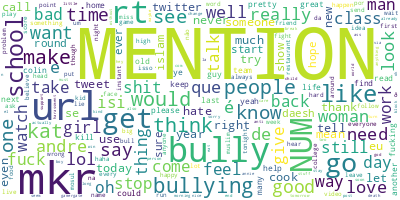

In [42]:
# Genera el wordcloud
wordcloud.generate(txt_cat0)
# Visualizalo en una imagen
wordcloud.to_image()

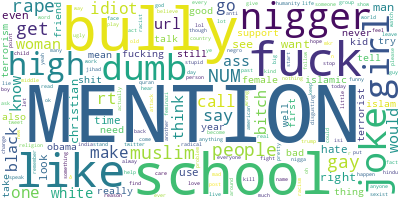

In [43]:
# Genera el wordcloud
wordcloud.generate(txt_cat1)
# Visualizalo en una imagen
wordcloud.to_image()

También antes de la vectorización, podemos calcular algunas características adicionales, como el número de URLs o menciones

In [44]:
def token_appearance(document, token = "MENTION"):
  return len([x for x in document.split() if x == token])

In [45]:
dataset["num_mention"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="MENTION"))
dataset["num_URLS"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="URL"))
dataset["num_NUM"] = dataset["preprocessed_text"].progress_apply(lambda x: token_appearance(x, token="NUM"))

  0%|          | 0/46017 [00:00<?, ?it/s]

  0%|          | 0/46017 [00:00<?, ?it/s]

  0%|          | 0/46017 [00:00<?, ?it/s]

In [46]:
dataset

,tweet_text,cyberbullying,char_len,normalized,preprocessed_text,num_mention,num_URLS,num_NUM
0,"In other words #katandandre, your food was cra...",0,61,"in other words #katandandre , your food was cr...",word katandandre food crapilicious mkr,0,0,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,115,why is #aussietv so white ? #mkr #theblock #im...,aussietv white mkr theblock imacelebrityau tod...,0,0,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0,60,MENTION a classy whore ? or more red velvet cu...,MENTION classy whore red velvet cupcake,1,0,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,103,"MENTION meh . :p thanks for the heads up , but...",MENTION meh thank head concerned another angry...,1,0,0
4,@RudhoeEnglish This is an ISIS account pretend...,0,103,MENTION this is an isis account pretending to ...,MENTION isis account pretend kurdish account l...,1,0,0
...,...,...,...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",1,234,"black people are not expected to do anything ,...",black people expect anything depend anything y...,0,0,0
47688,Turner did not withhold his disappointment. Tu...,1,276,turner did not withhold his disappointment . t...,turner withhold disappointment turner call cou...,0,0,0
47689,I swear to God. This dumb nigger bitch. I have...,1,104,i swear to god . this dumb nigger bitch . i ha...,swear god dumb nigger bitch get bleach hair re...,0,0,0
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,1,90,yea fuck you rt MENTION : if you are a nigger ...,yea fuck rt MENTION nigger fucking unfollow fu...,1,0,0


## 4. Vectorización

Con la función 'TfidfVectorizer' quiero que tenga en cuenta: No llevar a cabo preprocesados realizados previamente, considerar unigramas, bigramas y trigramas y que el sistema no considere los elementos que salgan en menos del 0.005% de los documentos.

In [47]:
vectorizador = TfidfVectorizer(lowercase=False,
                               ngram_range=(1,3),
                               min_df = 0.005)

In [48]:
vector_data = vectorizador.fit_transform(dataset["preprocessed_text"])

In [49]:
vector_data

<46017x408 sparse matrix of type '<class 'numpy.float64'>'
	with 382516 stored elements in Compressed Sparse Row format>

Obtengo como resultado del proceso de vectorización que nos devuelve vectores de tamaño 408.

**Incorporación de características adicionales**

Anteriormente he calculado algunas características que podrían ayudar al clasificador a tener mejor rendimiento. Ire a incorporarlas a la representación vectorial de los documentos.

La forma más sencilla sería a través de la librería Scipy y genenar la matriz sparse, comprensible por scikit-learn, que contenga tanto las características de TF-IDF como las calculadas manualmente.

Debemos seleccionar el conjunto de variables que queremos considerar en el entrenamiento. Para ello hacemos uso del selector dataframe[["nombre_columna1", "nombre_columna2"]]

In [50]:
extra_features = dataset[['num_mention','num_URLS','num_NUM']]

Utilizaré la librería scipy (función sparse.hstack) para unir las características TF-IDF (contenidas en 'vector_data') con las que acabamos de seleccionar ('extra_features'). Esta unión nos generará una matriz X que utilizare para el train_test_split.

In [51]:
import scipy as sp
# Extraemos las etiquetas y las asignamos a la variable y
y = dataset["cyberbullying"].values.astype(np.float32)
# Unimos las características TFIDF con las características previamente seleccionadas
# Extraemos los valores (values) de las extra_features, que es un dataframe
X = sp.sparse.hstack((vector_data,extra_features.values),format='csr')

Compruebo que las características fueron incorporadas correctamente.

In [52]:
vector_data

<46017x408 sparse matrix of type '<class 'numpy.float64'>'
	with 382516 stored elements in Compressed Sparse Row format>

In [53]:
X

<46017x411 sparse matrix of type '<class 'numpy.float64'>'
	with 404822 stored elements in Compressed Sparse Row format>

Después puedo extraer el nombre de las características por si quisieramos utilizarlos con posterioridad.

In [54]:
X_columns=list(vectorizador.get_feature_names_out())+extra_features.columns.tolist()

## 5. Entrenamiento y evaluación de modelos


Poseo un conjunto de características predictoras extraídas del texto (variable X), y las categorías asignadas manualmente en el conjunto de datos (y).

In [55]:
X

<46017x411 sparse matrix of type '<class 'numpy.float64'>'
	with 404822 stored elements in Compressed Sparse Row format>

Cuento con 411 características para 46017.

Procedo a realizar el muestreo.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,
                                                    random_state=0,
                                                    stratify = y)
print(X_train.shape)
print(X_test.shape)

(34512, 411)
(11505, 411)


**Decision de modelo de ML a utilizar**

En primer lugar se ha generado una función para medir la calidad de varios modelos estándar de forma fácil y ver sus resultados.

La función hace un KFold y evalua diferentes modelos con una métrica de evblauación:

In [57]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generamos un StratifiedKFold
          KF = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)

          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

Puedo ahora definir los modelos con los que hacer la evaluación. En mi caso he decidido incorporar la regresión logística, Naive Bayes y Random Forest Classifier.

In [58]:
# Cargamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB()),
         ("RandomForest",RandomForestClassifier())
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_train.toarray(), y_train)

Metric: accuracy , KFold 
Logistic: 0.858484 (0.002190) 
Metric: accuracy , KFold 
GaussianNB: 0.625667 (0.002874) 
Metric: accuracy , KFold 
RandomForest: 0.866858 (0.002769) 


([array([0.86093003, 0.86006084, 0.85728774, 0.85931614, 0.85482469]),
  array([0.62031001, 0.62697378, 0.62749928, 0.62518111, 0.62836859]),
  array([0.86585543, 0.86281327, 0.86583599, 0.86902347, 0.8707621 ])],
 ['Logistic', 'GaussianNB', 'RandomForest'])

Pude observar que el modelo con un mejor funcionamiento fue el RandomForest, que seria con el que intentaria afinar los hiperparámetros.

Lo ejecute anteriormente y el resultado demoro mucho en dar el output asi como imprimir los mejores resultados, por lo que lo intentare con Regresión Logística.

In [59]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

Voy a probar generar un diccionario para la búsqueda Grid y también generaremo el objeto GridSearchCV.

In [60]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

Entreno el modelo y hacemos un print para ver el mejor resultado.

In [61]:
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.858223 usando los parámetros {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


Tenemos el modelo con los mejores resultados que deben ser introducidos a un modelo específico para ser entrenado.

In [62]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=1, penalty="l2",solver="liblinear")
model.fit(X_train,y_train)

LogisticRegression(C=1, solver='liblinear')

Predecimos el conjunto de test, y creamos dicha matriz de confusion y un classification report para ver las metricas.

In [63]:
y_pred = model.predict(X_test)

In [64]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 860 1124]
 [ 501 9020]]
              precision    recall  f1-score   support

         0.0       0.63      0.43      0.51      1984
         1.0       0.89      0.95      0.92      9521

    accuracy                           0.86     11505
   macro avg       0.76      0.69      0.72     11505
weighted avg       0.84      0.86      0.85     11505



La presición de la categoría 0 es baja, por lo que se puede deber a que utilizamos todo el conjunto de datos, donde basicamente hasta 150 caracteres estaba balanceo, luego se veia una gran diferencia y decidimos usar todo para no perder información.

Puedo mostrar la matriz de confusión graficamente.

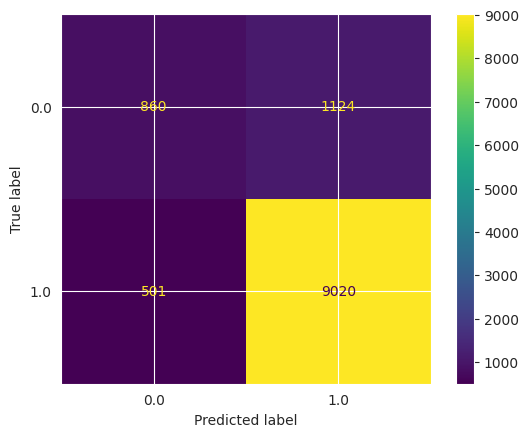

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize = None)

Si quisieramos aplicar el modelo a nuevos datos, tendríamos que preprocesarlo del mismo modo que a los datos de entrenamiento y deberíamos transformarlo con el TFIDFVectorizar anteriormente entrenado. Despues de eso ya se podría incorporar sin problemas al model.predict(Xnew)

**Importancia de características**

In [66]:
# Obtener la importancia de las variables del modelo
importance = model.coef_[0]

In [67]:
# Primero, emparejamos los nombres de las características con su importancia
features_importances = list(zip(X_columns, importance))

# Luego, ordenamos las características por importancia en orden descendente
features_importances_sorted = sorted(features_importances, key=lambda x: x[1], reverse=True)

# Desempaquetamos las listas ordenadas
X_columns_sorted, importance_sorted = zip(*features_importances_sorted)


Feature: 0, Name: nigger, Score: 6.45438
Feature: 1, Name: idiot, Score: 5.59411
Feature: 2, Name: rape, Score: 5.31996
Feature: 3, Name: muslim, Score: 5.31326
Feature: 4, Name: dumb, Score: 5.30326
Feature: 5, Name: feminazi, Score: 5.23356
Feature: 6, Name: school bully, Score: 5.11775
Feature: 7, Name: bitch, Score: 4.50789
Feature: 8, Name: radical, Score: 4.36836
Feature: 9, Name: christian woman, Score: 4.15151
Feature: 10, Name: death, Score: -0.53812
Feature: 11, Name: love, Score: -0.58132
Feature: 12, Name: happy, Score: -0.62090
Feature: 13, Name: isis, Score: -0.68789
Feature: 14, Name: andre, Score: -0.75646
Feature: 15, Name: NUM, Score: -1.19772
Feature: 16, Name: class, Score: -1.87930
Feature: 17, Name: mkr, Score: -2.37591
Feature: 18, Name: bullying, Score: -2.57852
Feature: 19, Name: kat andre, Score: -3.47757


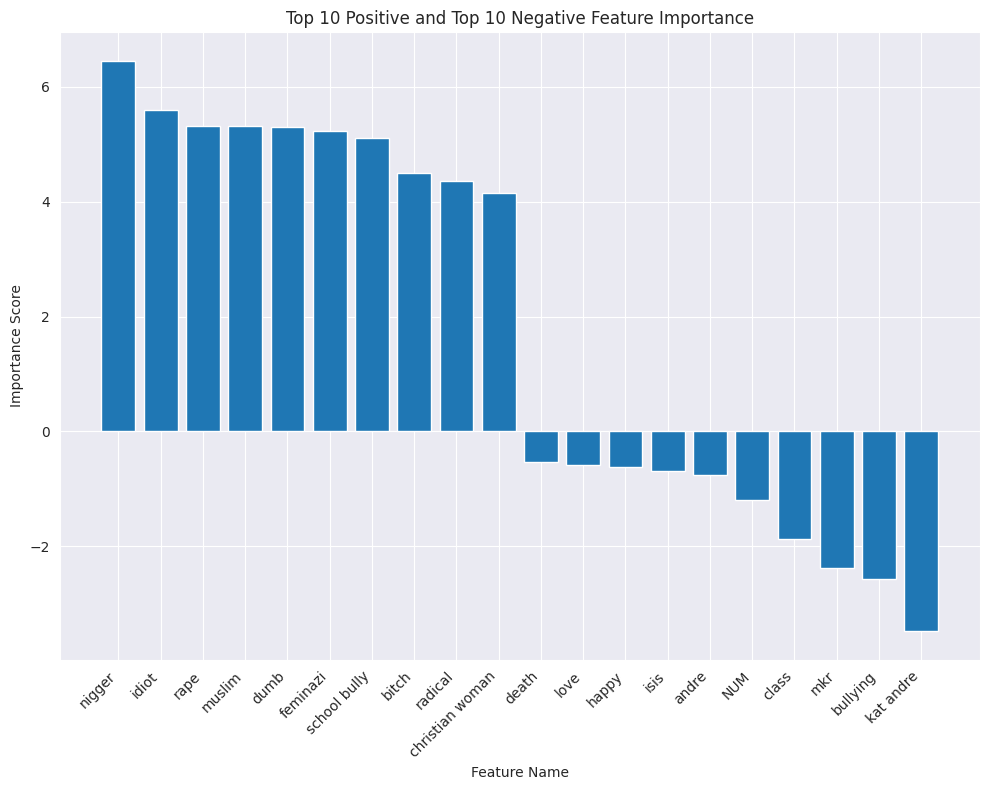

In [68]:
# Seleccionamos solo las 10 más positivas y las 10 más negativas
top_features = X_columns_sorted[:10] + X_columns_sorted[-10:]
top_importance = importance_sorted[:10] + importance_sorted[-10:]

# Mostrar el número de la característica, con su nombre, y su score de importancia
for i, (feature, importance) in enumerate(zip(top_features, top_importance)):
    print('Feature: %0d, Name: %s, Score: %.5f' % (i, feature, importance))

# Crear el plot
plt.figure(figsize=(10, 8))  # Ajusta el tamaño del gráfico según necesites
plt.bar(top_features, top_importance)  # Usar nombres de características ordenadas en el eje x

# Mejorar el gráfico
plt.xticks(rotation=45, ha="right")  # Rota los nombres en el eje x para mejor lectura
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')
plt.title('Top 10 Positive and Top 10 Negative Feature Importance')
plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot para que el subplot(s) encaje en el área de la figura.

plt.show()

**Ahora me gustaria realizar un rebalanceo de categorias y evaluar el modelo, adicionalmente.**

Primero, voy a aplicar SMOTE a los datos de entrenamiento.

In [69]:
# Instalar la librería imbalanced-learn si no está instalada
!pip install imbalanced-learn

# Importar la librería SMOTE
from imblearn.over_sampling import SMOTE

# Crear el objeto SMOTE y aplicar el rebalanceo a los datos de entrenamiento
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Verificar el resultado del rebalanceo
print("Distribución después del rebalanceo:")
print(np.array(np.unique(y_res, return_counts=True)).T)

Distribución después del rebalanceo:
[[0.0000e+00 2.8559e+04]
 [1.0000e+00 2.8559e+04]]


Ahora realizare el reentrenamiento del modelo con datos rebalanceados con el modelo de regresión logística.

In [70]:
# Definir el modelo de regresión logística con los mejores parámetros encontrados anteriormente
model_rebalanced = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')

# Entrenar el modelo con los datos reequilibrados
model_rebalanced.fit(X_res, y_res)

LogisticRegression(solver='liblinear')

Ahora, voy a evaluar el modelo reentrenado con el conjunto de prueba y comparar los resultados con el modelo anterior.

Matriz de confusión después del rebalanceo:
[[1732  252]
 [1790 7731]]
Informe de clasificación después del rebalanceo:
              precision    recall  f1-score   support

         0.0       0.49      0.87      0.63      1984
         1.0       0.97      0.81      0.88      9521

    accuracy                           0.82     11505
   macro avg       0.73      0.84      0.76     11505
weighted avg       0.89      0.82      0.84     11505



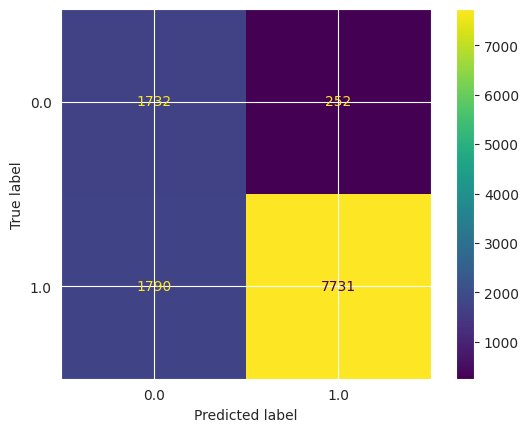

In [71]:
# Predecir el conjunto de prueba
y_pred_res = model_rebalanced.predict(X_test)

# Mostrar la matriz de confusión y el informe de clasificación
from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de confusión después del rebalanceo:")
print(confusion_matrix(y_test, y_pred_res))

print("Informe de clasificación después del rebalanceo:")
print(classification_report(y_test, y_pred_res))

# Mostrar la matriz de confusión gráficamente
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model_rebalanced, X_test, y_test, normalize=None)

**Conclusión sobre el Rebalanceo de Clases**

Después de aplicar el rebalanceo de clases con SMOTE y reevaluar el modelo de regresión logística, se observan varios cambios importantes en el rendimiento del modelo. La precisión para la clase minoritaria (0.0) disminuyó de 0.63 a 0.49, pero el recall aumentó significativamente de 0.43 a 0.87. Esto indica que el modelo es ahora más capaz de identificar tweets con contenido de odio, aunque con una mayor tasa de falsos positivos. Para la clase mayoritaria (1.0), la precisión aumentó de 0.89 a 0.97, mientras que el recall disminuyó de 0.95 a 0.81. La precisión general del modelo (accuracy) disminuyó ligeramente de 0.86 a 0.82. En resumen, el rebalanceo ha permitido mejorar la capacidad del modelo para detectar tweets de ciberacoso (clase 0.0) a expensas de una menor precisión. Este enfoque puede ser beneficioso en aplicaciones donde es crucial minimizar los falsos negativos y asegurar que los tweets con contenido de odio sean identificados de manera más efectiva, mejorando así la capacidad del modelo para detectar y abordar el ciberacoso.